In [ ]:
import numpy as np

In [3]:
with open("likelihood.txt", "r") as f:
    bird_likelihood, aero_likelihood = f.readlines()

bird_likelihood = np.array([float(datum) for datum in bird_likelihood.split()])
aero_likelihood = np.array([float(datum) for datum in aero_likelihood.split()])
len(bird_likelihood), len(aero_likelihood)

(400, 400)

In [4]:
with open("dataset.txt", "r") as f:
    dataset = f.read()
    
dataset = np.array([[float(datum) for datum in row.split()] for row in dataset.strip().split("\n")])
bird_velocities = dataset[:10]
aero_velocities = dataset[10:]

len(bird_velocities[0]), len(aero_velocities[-1])

(600, 600)

In [5]:
bird_velocities.shape

(10, 600)

In [4]:
with open("testing.txt", "r") as f:
    testing = f.read()

testing = np.array([[float(datum) for datum in row.split()] for row in testing.strip().split("\n")])
bird_test = testing[:5]
aero_test = testing[5:]

len(bird_test[0]), len(aero_test[0])

(600, 600)

In [5]:
# P(speed | b): probability of observing a bird's speed
# P(speed | a): probability of observing a airplane's speed

# P(a_t+1 | a_t) = .9; P(b_t+1 | b_t) = .9
# P(a_t+1 | b_t) = .1; P(b_t+1 | a_t) = .1

# P(a) = .5
# P(b) = .5

In [6]:
# for a single obs
min_speed = np.min(bird_velocities[0])
max_speed = np.max(bird_velocities[0])
normalized_speeds = (bird_velocities[0] - min_speed)/(max_speed - min_speed)

indices = (normalized_speeds * (len(bird_likelihood)-1)).astype(int)
first_row_likelihoods = bird_likelihood[indices]

In [7]:
def speed2likelihood(speeds, bird=True):
    indices = (speeds * 2).astype(int)
    max_likelihood_index = len(bird_likelihood) - 1
    indices = np.clip(indices, 0, max_likelihood_index)

    if bird:
        return bird_likelihood[indices]
    else:
        return aero_likelihood[indices]

In [8]:
test_bird_row = bird_velocities[0]
test_aero_row = aero_velocities[0]
test_row_bird_likelihoods = speed2likelihood(test_bird_row)
test_row_aero_likelihoods = speed2likelihood(test_aero_row, bird=False)

In [9]:
i = 0

# observed likelihoods
obs_likelihood_bird = test_row_bird_likelihoods[i]
obs_likelihood_aero = test_row_aero_likelihoods[i]

# priors
prob_bird = .5
prob_aero = .5

In [10]:
# posterior update
# p(b /\ speed) = p(speed | b) * p(b)
# p(a /\ speed) = p(speed | a) * p(a)

bird_post_update = obs_likelihood_bird * prob_bird
aero_post_update = obs_likelihood_aero * prob_aero

# normalization
bird_normed = bird_post_update/(bird_post_update + aero_post_update)
aero_normed = aero_post_update/(bird_post_update + aero_post_update)

In [11]:
bird_normed, aero_normed

(np.float64(0.9030574638043971), np.float64(0.09694253619560289))

In [12]:
# iteration 2
i = 1

# observed likelihoods
obs_likelihood_bird = test_row_bird_likelihoods[i]
obs_likelihood_aero = test_row_aero_likelihoods[i]

# transition probabilities
prob_bird = bird_normed * .9 + aero_normed * .1
prob_aero = aero_normed * .9 + bird_normed * .1

In [13]:
bird_post_update = obs_likelihood_bird * prob_bird
aero_post_update = obs_likelihood_aero * prob_aero

bird_normed = bird_post_update/(bird_post_update + aero_post_update)
aero_normed = aero_post_update/(bird_post_update + aero_post_update)

In [14]:
bird_normed, aero_normed

(np.float64(0.9564670147962513), np.float64(0.043532985203748695))

In [15]:
prob_bird = .5
prob_aero = .5

for j in range(len(bird_velocities)):
    print(j)
    bird_row = bird_velocities[j]
    aero_row = aero_velocities[j]

    row_bird_likelihoods = speed2likelihood(bird_row)
    row_aero_likelihoods = speed2likelihood(aero_row, bird=False)

    for i in range(len(row_bird_likelihoods)):
        obs_likelihood_bird = row_bird_likelihoods[i]
        obs_likelihood_aero = row_aero_likelihoods[i]

        if not obs_likelihood_aero:
            continue
        if not obs_likelihood_bird:
            continue

        if i != 0:
            prob_bird = bird_normed * .9 + aero_normed * .1
            prob_aero = aero_normed * .9 + bird_normed * .1

        bird_post_update = obs_likelihood_bird * prob_bird
        aero_post_update = obs_likelihood_aero * prob_aero

        total = bird_post_update + aero_post_update
        if total > 0:
            bird_normed = bird_post_update/total
            aero_normed = aero_post_update/total

0
1
2
3
4
5
6
7
8
9


/tmp/ipykernel_1956/154105515.py:2: RuntimeWarning: invalid value encountered in cast
  indices = (speeds * 2).astype(int)


In [16]:
bird_normed, aero_normed

(np.float64(0.8088557341316833), np.float64(0.1911442658683167))

In [17]:
bird_test[0].shape

(600,)

In [18]:
prob_bird = .5
prob_aero = .5

test_sequence = aero_test[1]

predictions = []
bird_probs = []

bird_likelihoods = speed2likelihood(test_sequence)
aero_likelihoods = speed2likelihood(test_sequence, bird=False)

for i in range(len(test_sequence)):
    obs_likelihood_bird = bird_likelihoods[i]
    obs_likelihood_aero = aero_likelihoods[i]

    if (np.nan_to_num(obs_likelihood_aero, nan=0) == 0) or (np.nan_to_num(obs_likelihood_bird, nan=0) == 0):
        if len(predictions) > 0:
            predictions.append(predictions[-1])
            bird_probs.append(bird_probs[-1])
        else:
            predictions.append(1 if prob_bird > .5 else 0)
            bird_probs.append(prob_bird)
        continue

    if i != 0:
        prob_bird = bird_normed * .9 + aero_normed * .1
        prob_aero = aero_normed * .9 + bird_normed * .1

    bird_post_update = obs_likelihood_bird * prob_bird
    aero_post_update = obs_likelihood_aero * prob_aero
    
    total = bird_post_update + aero_post_update
    if total > 0:
        bird_normed = bird_post_update/total
        aero_normed = aero_post_update/total 
    else:
        bird_normed = prob_bird
        aero_normed = prob_aero

    prediction = 1 if bird_normed > aero_normed else 0
    predictions.append(prediction)
    bird_probs.append(bird_normed)  

/tmp/ipykernel_1956/154105515.py:2: RuntimeWarning: invalid value encountered in cast
  indices = (speeds * 2).astype(int)


In [19]:
np.array(predictions)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [20]:
bird_velocities

array([[ 39.7729146,  31.4560402,  33.4170107, ...,  32.5056427,
         45.8392516,  43.3522408],
       [ 54.4678706,  53.1748936,  51.823815 , ...,  61.0997086,
         61.3669595,  52.2395468],
       [105.987538 ,  71.160984 ,  90.3234012, ...,  64.7142439,
         92.7858943,  88.8550812],
       ...,
       [ 64.989871 ,  72.709577 ,  66.8047291, ...,  69.3392612,
         61.2426196,  61.1307175],
       [ 69.0527409,  69.1201256,  66.9925442, ...,  68.3797374,
         65.2004555,  67.0602814],
       [ 64.9747563,  57.6952347,  46.1480956, ...,  49.3756172,
         45.4942656,  45.6228844]], shape=(10, 600))

In [21]:
test_accel = np.gradient(bird_velocities[0])

accel_indices = (test_accel * 2).astype(int)
max_likelihood_index = len(bird_likelihood) - 1
accel_indices = np.clip(accel_indices, 0, max_likelihood_index)

vel_indices = (bird_velocities[0] * 2).astype(int)
vel_indices = np.clip(vel_indices, 0, max_likelihood_index)

(array([  4.,  26.,  39.,  83., 111., 128.,  90.,  69.,  32.,  18.]),
 array([-11.6132138 ,  -9.42987757,  -7.24654133,  -5.0632051 ,
         -2.87986886,  -0.69653263,   1.48680361,   3.67013984,
          5.85347608,   8.03681231,  10.22014855]),
 <BarContainer object of 10 artists>)

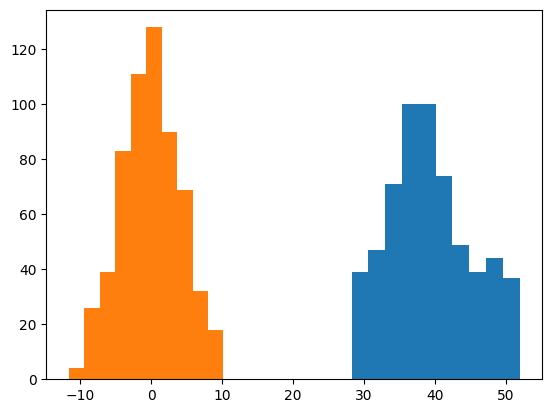

In [22]:
import matplotlib.pyplot as plt

plt.hist(bird_velocities[0])
plt.hist(test_accel)

In [38]:
counts, bin_edges = np.histogram(test_accel, bins=400, density=True)
likelihood = counts / np.sum(counts) if np.sum(counts) > 0 else counts
likelihood

array([0.00166667, 0.        , 0.        , 0.        , 0.00166667,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00166667, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00166667,
       0.        , 0.00166667, 0.        , 0.00166667, 0.        ,
       0.00166667, 0.        , 0.        , 0.        , 0.00333333,
       0.00166667, 0.        , 0.        , 0.        , 0.00166667,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00333333, 0.00166667, 0.        , 0.00166667, 0.00333333,
       0.00166667, 0.00166667, 0.00166667, 0.        , 0.        ,
       0.        , 0.00166667, 0.005     , 0.        , 0.     

In [39]:
likelihood.shape, bird_likelihood.shape

((400,), (400,))

In [45]:
def accel2likelihood(accels):
    counts, _ = np.histogram(accels, bins=600, density=True)
    likelihood = counts / np.sum(counts) if np.sum(counts) > 0 else counts
    return likelihood

In [50]:
prob_bird = .5
prob_aero = .5

for j in range(len(bird_velocities)):
    bird_row = np.nan_to_num(bird_velocities[j], nan=0)
    aero_row = np.nan_to_num(aero_velocities[j], nan=0)

    bird_accel = np.gradient(bird_row)
    aero_accel = np.gradient(aero_row)

    veloc_bird_likelihoods = speed2likelihood(bird_row)
    veloc_aero_likelihoods = speed2likelihood(aero_row, bird=False)

    accel_bird_likelihoods = accel2likelihood(bird_row)
    accel_aero_likelihoods = accel2likelihood(aero_row)

    for i in range(len(veloc_bird_likelihoods)):
        obs_likelihood_bird = veloc_bird_likelihoods[i] * accel_bird_likelihoods[i]
        obs_likelihood_aero = veloc_aero_likelihoods[i] * accel_aero_likelihoods[i]

        if not obs_likelihood_aero:
            continue
        if not obs_likelihood_bird:
            continue

        if i != 0:
            prob_bird = bird_normed * .9 + aero_normed * .1
            prob_aero = aero_normed * .9 + bird_normed * .1

        bird_post_update = obs_likelihood_bird * prob_bird
        aero_post_update = obs_likelihood_aero * prob_aero

        total = bird_post_update + aero_post_update
        if total > 0:
            bird_normed = bird_post_update/total
            aero_normed = aero_post_update/total

In [51]:
bird_normed, aero_normed

(np.float64(0.4518850197236631), np.float64(0.548114980276337))

In [59]:
prob_bird = .5
prob_aero = .5

test_sequence = np.nan_to_num(aero_test[2], nan=0)
test_sequence_accel = np.gradient(test_sequence)

predictions = []
bird_probs = []

bird_likelihoods = speed2likelihood(test_sequence)
aero_likelihoods = speed2likelihood(test_sequence, bird=False)

accel_likelihoods = accel2likelihood(test_sequence_accel)

for i in range(len(test_sequence)):
    obs_likelihood_bird = bird_likelihoods[i] * accel_likelihoods[i]
    obs_likelihood_aero = aero_likelihoods[i] * accel_likelihoods[i]

    if (np.nan_to_num(obs_likelihood_aero, nan=0) == 0) or (np.nan_to_num(obs_likelihood_bird, nan=0) == 0):
        if len(predictions) > 0:
            predictions.append(predictions[-1])
            bird_probs.append(bird_probs[-1])
        else:
            predictions.append(1 if prob_bird > .5 else 0)
            bird_probs.append(prob_bird)
        continue

    if i != 0:
        prob_bird = bird_normed * .9 + aero_normed * .1
        prob_aero = aero_normed * .9 + bird_normed * .1

    bird_post_update = obs_likelihood_bird * prob_bird
    aero_post_update = obs_likelihood_aero * prob_aero
    
    total = bird_post_update + aero_post_update
    if total > 0:
        bird_normed = bird_post_update/total
        aero_normed = aero_post_update/total 
    else:
        bird_normed = prob_bird
        aero_normed = prob_aero

    prediction = 1 if bird_normed > aero_normed else 0
    predictions.append(prediction)
    bird_probs.append(bird_normed)  

In [60]:
np.array(predictions)

array([1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [1]:
from bayesian_networks import BayesianNetwork, BIRD_TEST, AERO_TEST

bn_no_accel = BayesianNetwork()
bn_accel = BayesianNetwork(accel=True)
bn_no_accel.fit()
bn_accel.fit()

0.8516010610481524 0.14839893895184766
(600,)
-488
-186
437
-42
-160
110
-220
21
-52
-206
469
420
-39
-57
-262
-243
195
258
-279
109
-72
-288
148
24
183
31
-407
-64
316
300
185
-305
-277
0
-74
-152
148
370
234
-207
-305
-136
-202
320
123
-233
484
18
-423
-57
-42
208
310
-154
-228
12
309
377
-508
-271
187
224
-28
-131
-82
-65
371
-56
-366
16
-85
97
269
-177
-301
178
348
-170
183
2
-211
141
-83
-2
-118
114
290
-216
-80
71
316
-172
-536
152
363
12
-52
-121
-166
66
-104
222
179
-97
304
-243
-175
322
-275
-146
25
-247
17
208
-202
313
169
-453
323
219
-212
-51
-161
-66
71
106
-31
-228
-6
552
283
-518
-142
-156
-42
393
87
-176
0
121
-145
-83
427
-133
2
332
-243
20
-379
-235
590
-143
-6
352
-342
-359
41
-50
-45
268
-185
-272
177
537
131
-215
132
-230
-40
-13
60
178
-313
30
44
-123
10
103
-92
-241
108
600


IndexError: index 600 is out of bounds for axis 0 with size 600

In [2]:
preds_no_accel, probs_no_accel = bn_no_accel.predict(AERO_TEST[1])

In [3]:
preds_no_accel

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [3]:
import numpy as np

for test_sequence in BIRD_TEST:
    preds_no_accel, _ = bn_no_accel.predict(test_sequence)
    preds_accel, _ = bn_accel.predict(test_sequence)

    most_freq_no_accel = np.argmax(np.bincount(preds_no_accel))
    most_freq_accel = np.argmax(np.bincount(preds_accel))

    print(most_freq_no_accel, most_freq_accel)

1 1
1 1
1 1
1 1
1 1
